<a href="https://colab.research.google.com/github/tushtithakur/Corona-Virus-Outbreak-Prediction/blob/main/Daily_Coronavirus_Cases_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Forecasting with LSTMs for Daily Coronavirus Cases using PyTorch in Python

In [ ]:
!pip install -Uq watermark

In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch

CPython 3.6.9
IPython 5.5.0

numpy 1.17.5
pandas 0.25.3
torch 1.4.0


In [ ]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [ ]:
!gdown --id 1AsfdLrGESCQnRW5rbMz56A1KBc3Fe5aV

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1AsfdLrGESCQnRW5rbMz56A1KBc3Fe5aV
To: /content/time_series_19-covid-Confirmed.csv
100% 19.2k/19.2k [00:00<00:00, 79.1MB/s]


## Data exploration


In [ ]:
df = pd.read_csv('time_series_19-covid-Confirmed.csv')
df.head()

Province/State  Country/Region      Lat  ...  2/29/20  3/1/20  3/2/20
0          Anhui  Mainland China  31.8257  ...      990     990     990
1        Beijing  Mainland China  40.1824  ...      411     413     414
2      Chongqing  Mainland China  30.0572  ...      576     576     576
3         Fujian  Mainland China  26.0789  ...      296     296     296
4          Gansu  Mainland China  36.0611  ...       91      91      91

[5 rows x 45 columns]

In [ ]:
df = df.iloc[:, 4:]

In [ ]:
df.head()

1/22/20  1/23/20  1/24/20  1/25/20  ...  2/28/20  2/29/20  3/1/20  3/2/20
0        1        9       15       39  ...      990      990     990     990
1       14       22       36       41  ...      410      411     413     414
2        6        9       27       57  ...      576      576     576     576
3        1        5       10       18  ...      296      296     296     296
4        0        2        2        4  ...       91       91      91      91

[5 rows x 41 columns]

Let's check for missing values:

In [ ]:
df.isnull().sum().sum()

0

In [ ]:
daily_cases = df.sum(axis=0)
daily_cases.index = pd.to_datetime(daily_cases.index)
daily_cases.head()

2020-01-22     555
2020-01-23     653
2020-01-24     941
2020-01-25    1434
2020-01-26    2118
dtype: int64

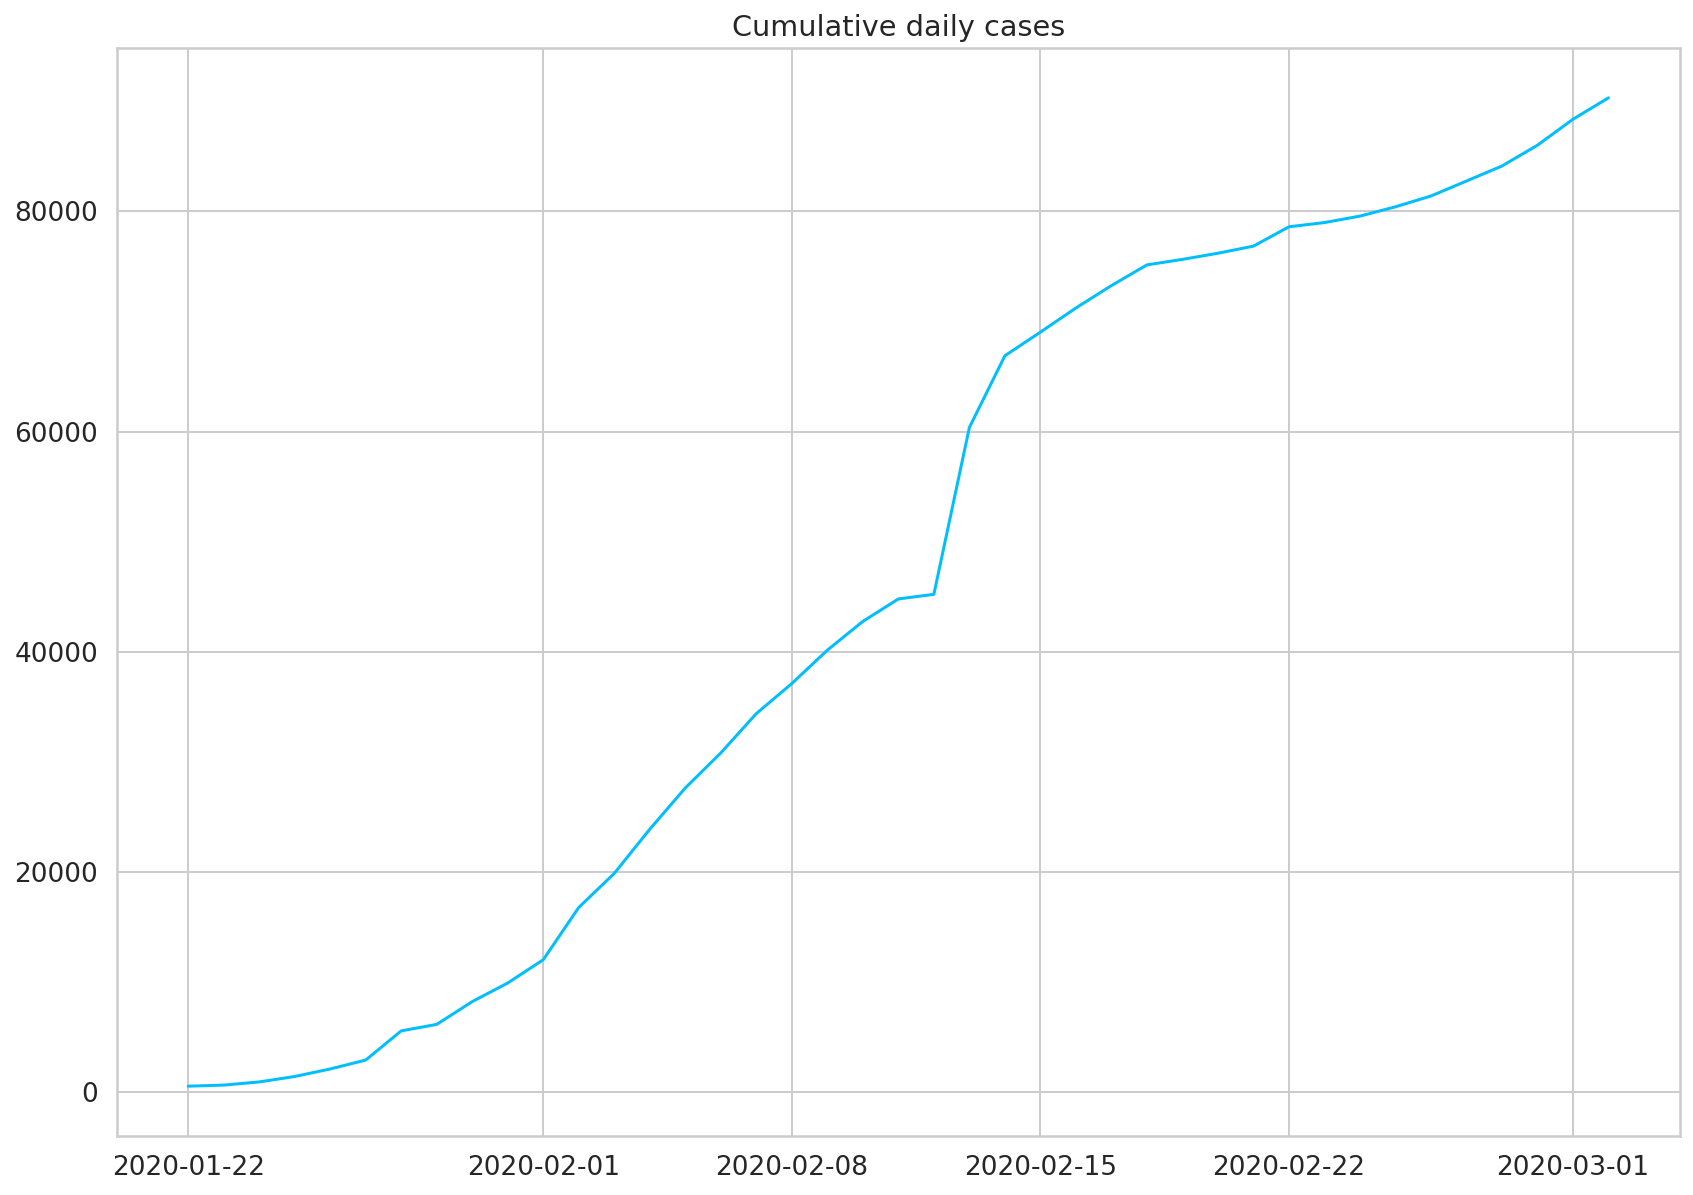

In [ ]:
plt.plot(daily_cases)
plt.title("Cumulative daily cases");

In [ ]:
daily_cases = daily_cases.diff().fillna(daily_cases[0]).astype(np.int64)
daily_cases.head()

2020-01-22    555
2020-01-23     98
2020-01-24    288
2020-01-25    493
2020-01-26    684
dtype: int64

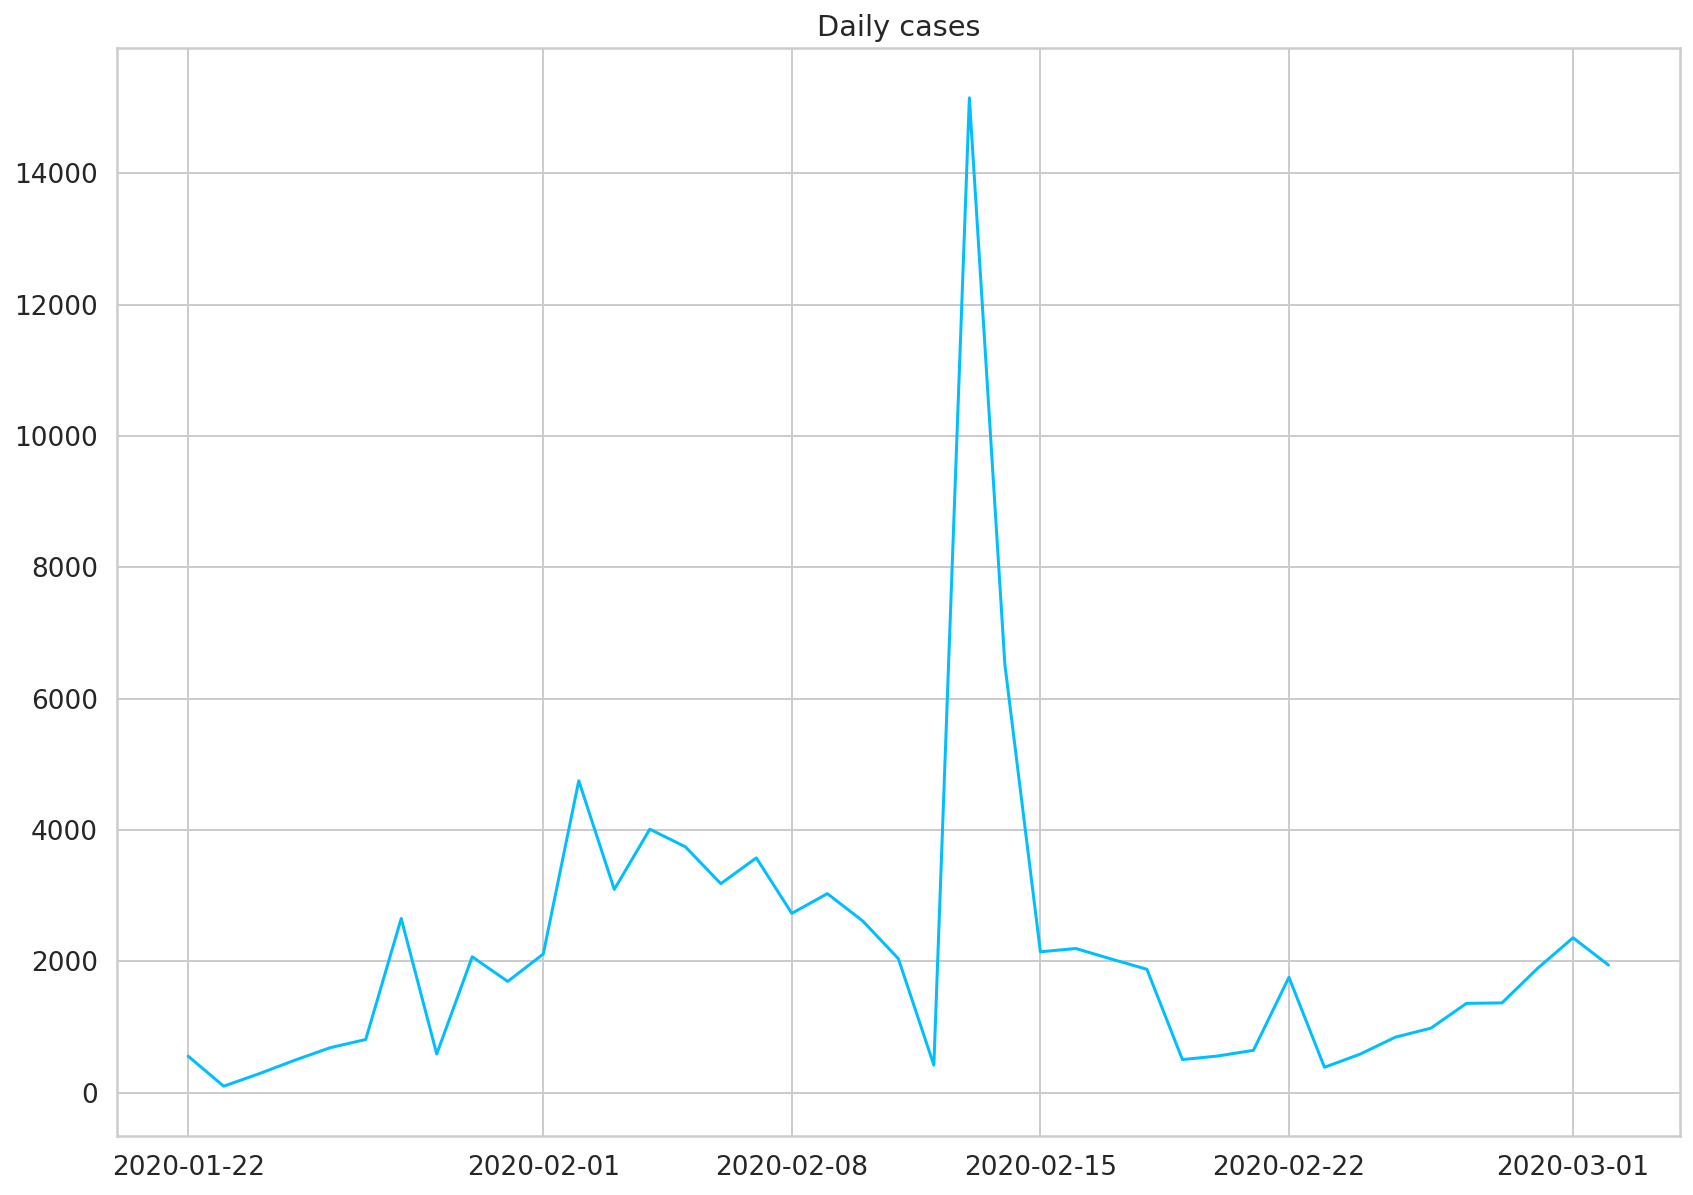

In [ ]:
plt.plot(daily_cases)
plt.title("Daily cases");

In [ ]:
daily_cases.shape

(41,)

## Preprocessing

We'll reserve the first 27 days for training and use the rest for testing:

In [ ]:
test_data_size = 14

train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]

train_data.shape

(27,)

In [ ]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(train_data, axis=1))

train_data = scaler.transform(np.expand_dims(train_data, axis=1))

test_data = scaler.transform(np.expand_dims(test_data, axis=1))

Currently, we have a big sequence of daily cases. We'll convert it into smaller ones:

In [ ]:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [ ]:
seq_length = 5
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [ ]:
X_train.shape

torch.Size([21, 5, 1])

In [ ]:
X_train[:2]

tensor([[[0.0304],
         [0.0000],
         [0.0126],
         [0.0262],
         [0.0389]],

        [[0.0000],
         [0.0126],
         [0.0262],
         [0.0389],
         [0.0472]]])

In [ ]:
y_train.shape

torch.Size([21, 1])

In [ ]:
y_train[:2]

tensor([[0.0472],
        [0.1696]])

In [ ]:
train_data[:10]

array([[0.03036545],
       [0.        ],
       [0.01262458],
       [0.02624585],
       [0.03893688],
       [0.04724252],
       [0.16963455],
       [0.03255814],
       [0.13089701],
       [0.10598007]])

## Building a model

We'll encapsulate the complexity of our model into a class that extends from `torch.nn.Module`:

In [ ]:
class CoronaVirusPredictor(nn.Module):

  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(CoronaVirusPredictor, self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers

    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.5
    )

    self.linear = nn.Linear(in_features=n_hidden, out_features=1)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred

## Training

Let's build a helper function for the training of our model (we'll reuse it later):

In [ ]:
def train_model(
  model,
  train_data,
  train_labels,
  test_data=None,
  test_labels=None
):
  loss_fn = torch.nn.MSELoss(reduction='sum')

  optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
  num_epochs = 60

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
    model.reset_hidden_state()

    y_pred = model(X_train)

    loss = loss_fn(y_pred.float(), y_train)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

      if t % 10 == 0:
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()

    optimiser.zero_grad()

    loss.backward()

    optimiser.step()

  return model.eval(), train_hist, test_hist

In [ ]:
model = CoronaVirusPredictor(
  n_features=1,
  n_hidden=512,
  seq_len=seq_length,
  n_layers=2
)
model, train_hist, test_hist = train_model(
  model,
  X_train,
  y_train,
  X_test,
  y_test
)

Epoch 0 train loss: 1.6297188997268677 test loss: 0.041186608374118805
Epoch 10 train loss: 0.8466923832893372 test loss: 0.12416432797908783
Epoch 20 train loss: 0.8219934105873108 test loss: 0.1438201516866684
Epoch 30 train loss: 0.8200693726539612 test loss: 0.2190694659948349
Epoch 40 train loss: 0.810839056968689 test loss: 0.1797715127468109
Epoch 50 train loss: 0.795730471611023 test loss: 0.19855864346027374


Let's have a look at the train and test loss:

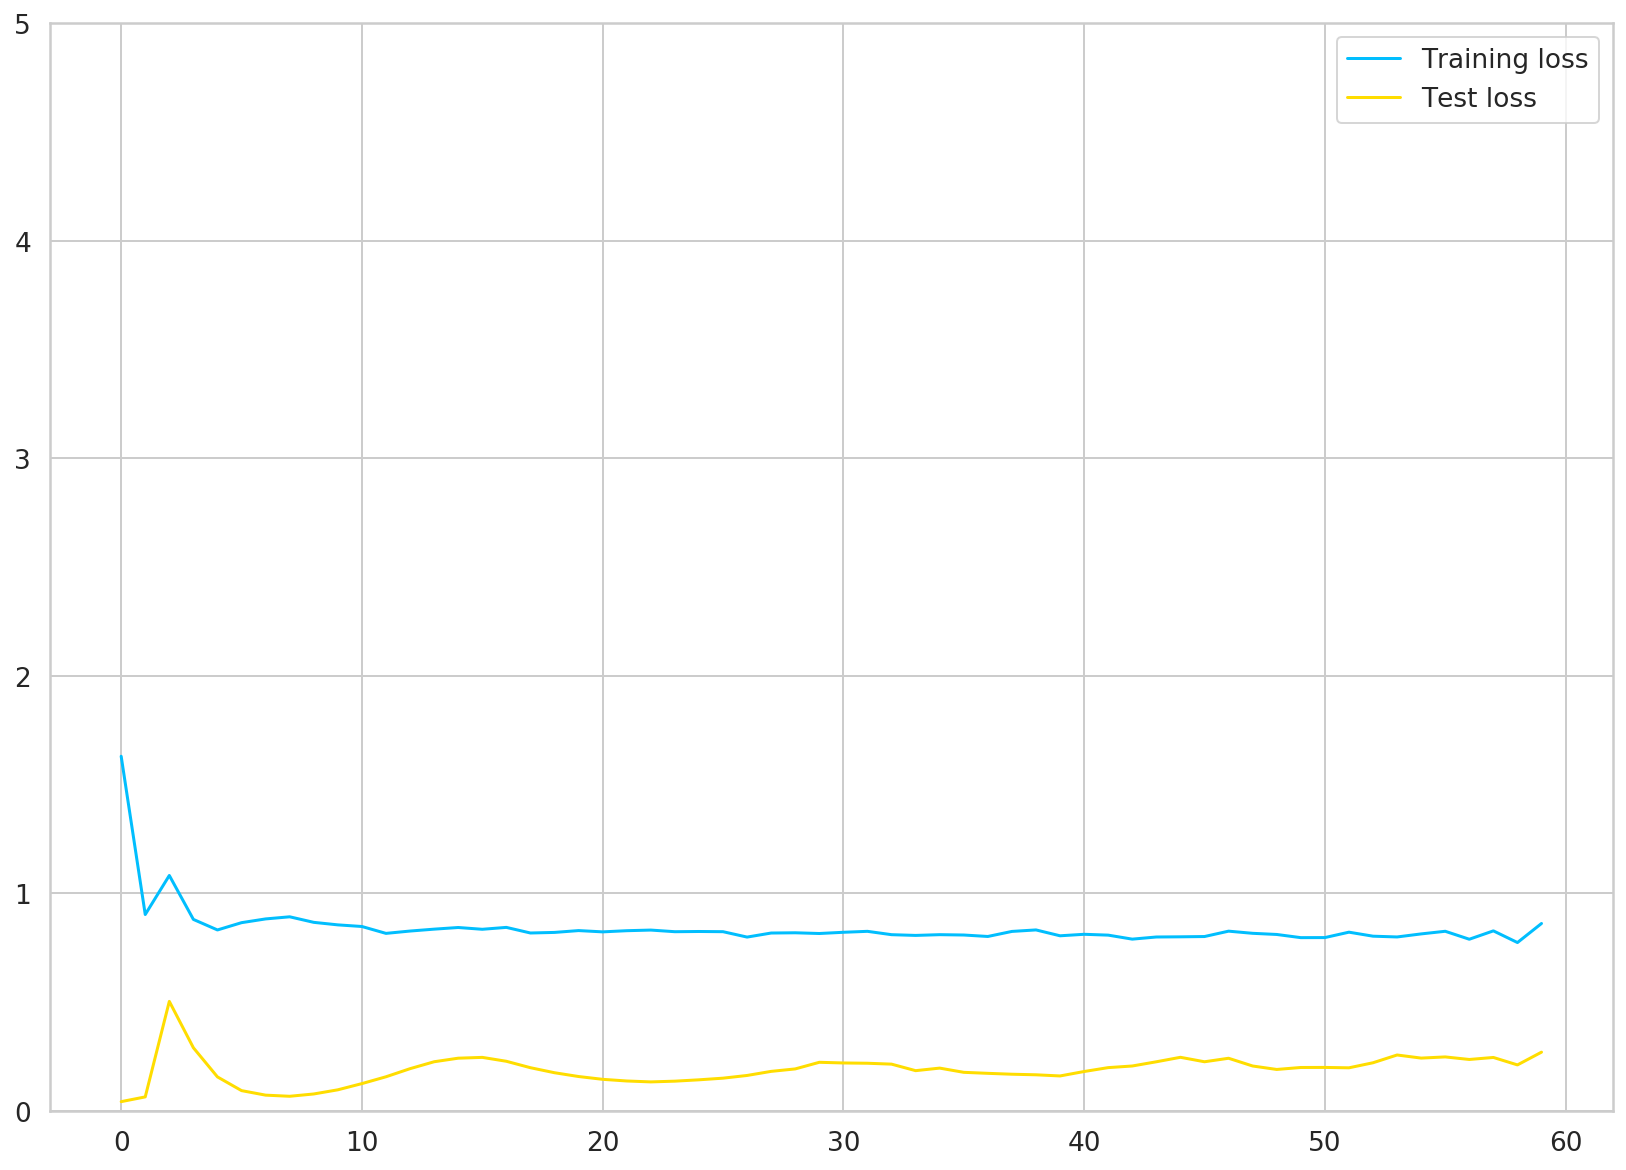

In [ ]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.ylim((0, 5))
plt.legend();

Our model's performance doesn't improve after 15 epochs or so. Recall that we have very little data. Maybe we shouldn't trust our model that much?

## Predicting daily cases

Our model can (due to the way we've trained it) predict only a single day in the future. We'll employ a simple strategy to overcome this limitation. Use predicted values as input for predicting the next days:

In [ ]:
with torch.no_grad():
  test_seq = X_test[:1]
  preds = []
  for _ in range(len(X_test)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

We have to reverse the scaling of the test data and the model predictions:

In [ ]:
true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

Let's look at the results:

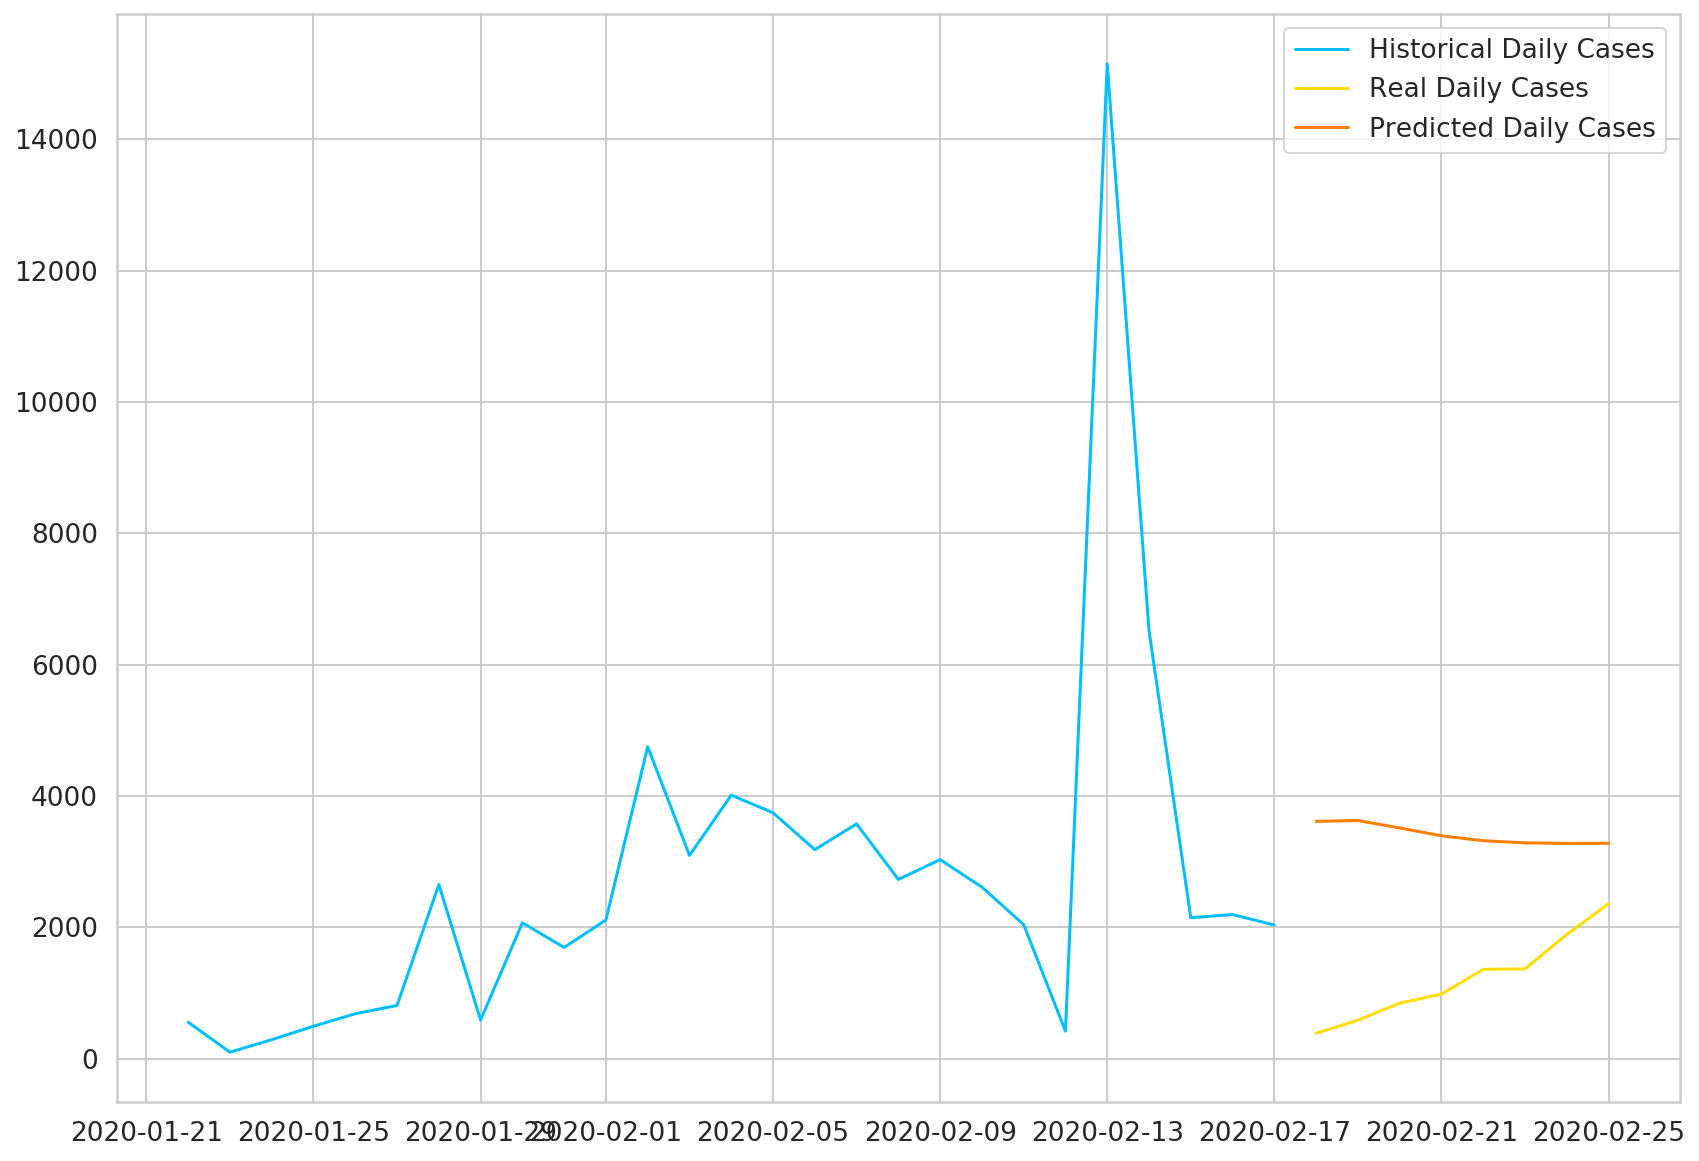

In [ ]:
plt.plot(
  daily_cases.index[:len(train_data)],
  scaler.inverse_transform(train_data).flatten(),
  label='Historical Daily Cases'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)],
  true_cases,
  label='Real Daily Cases'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)],
  predicted_cases,
  label='Predicted Daily Cases'
)

plt.legend();

## Use all data for training

Now, we'll use all available data to train the same model:

In [ ]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(daily_cases, axis=1))

all_data = scaler.transform(np.expand_dims(daily_cases, axis=1))

all_data.shape

(41, 1)

The preprocessing and training steps are the same:

In [ ]:
X_all, y_all = create_sequences(all_data, seq_length)

X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()

model = CoronaVirusPredictor(
  n_features=1,
  n_hidden=512,
  seq_len=seq_length,
  n_layers=2
)
model, train_hist, _ = train_model(model, X_all, y_all)

Epoch 0 train loss: 1.9441421031951904
Epoch 10 train loss: 0.8385428786277771
Epoch 20 train loss: 0.8256545066833496
Epoch 30 train loss: 0.8023681640625
Epoch 40 train loss: 0.8125611543655396
Epoch 50 train loss: 0.8225002884864807


## Predicting future cases

We'll use our "fully trained" model to predict the confirmed cases for 12 days into the future:

In [ ]:
DAYS_TO_PREDICT = 12

with torch.no_grad():
  test_seq = X_all[:1]
  preds = []
  for _ in range(DAYS_TO_PREDICT):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

As before, we'll inverse the scaler transformation:

In [ ]:
predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

To create a cool chart with the historical and predicted cases, we need to extend the date index of our data frame:

In [ ]:
daily_cases.index[-1]

Timestamp('2020-03-02 00:00:00')

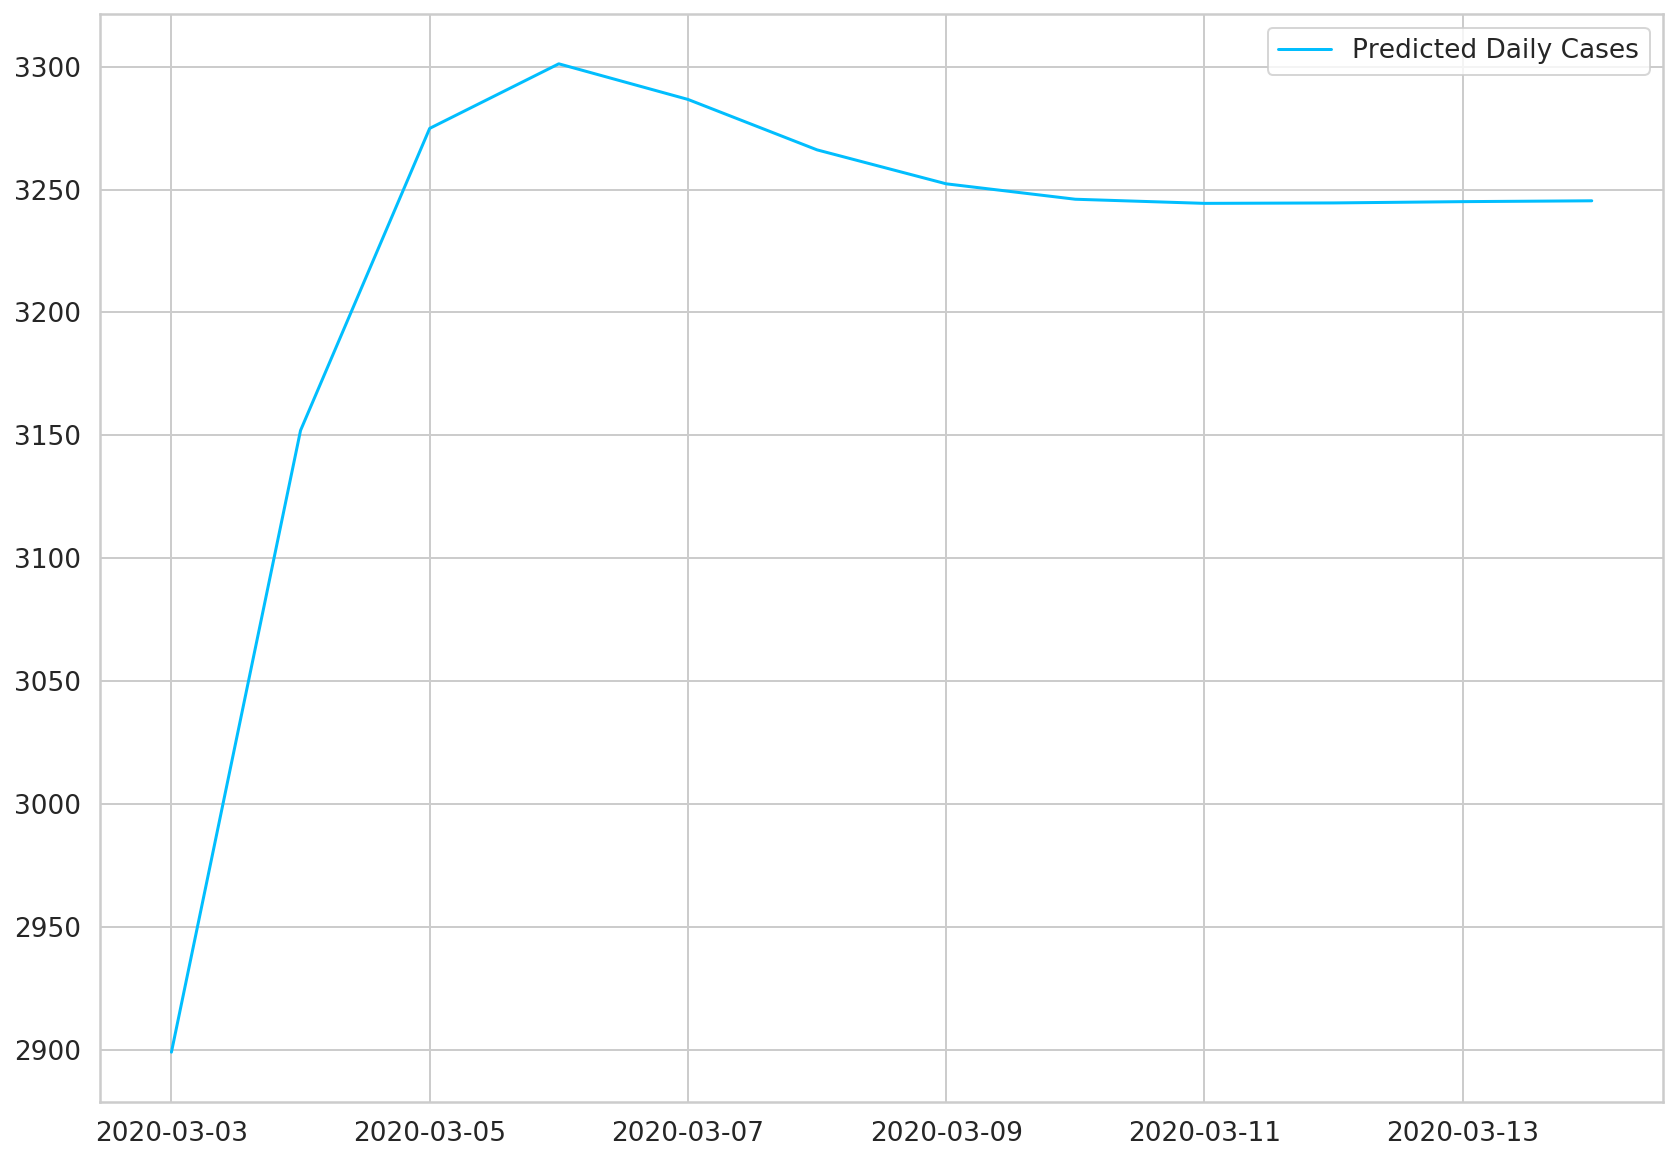

In [ ]:
predicted_index = pd.date_range(
  start=daily_cases.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

Now we can use all the data to plot the results:

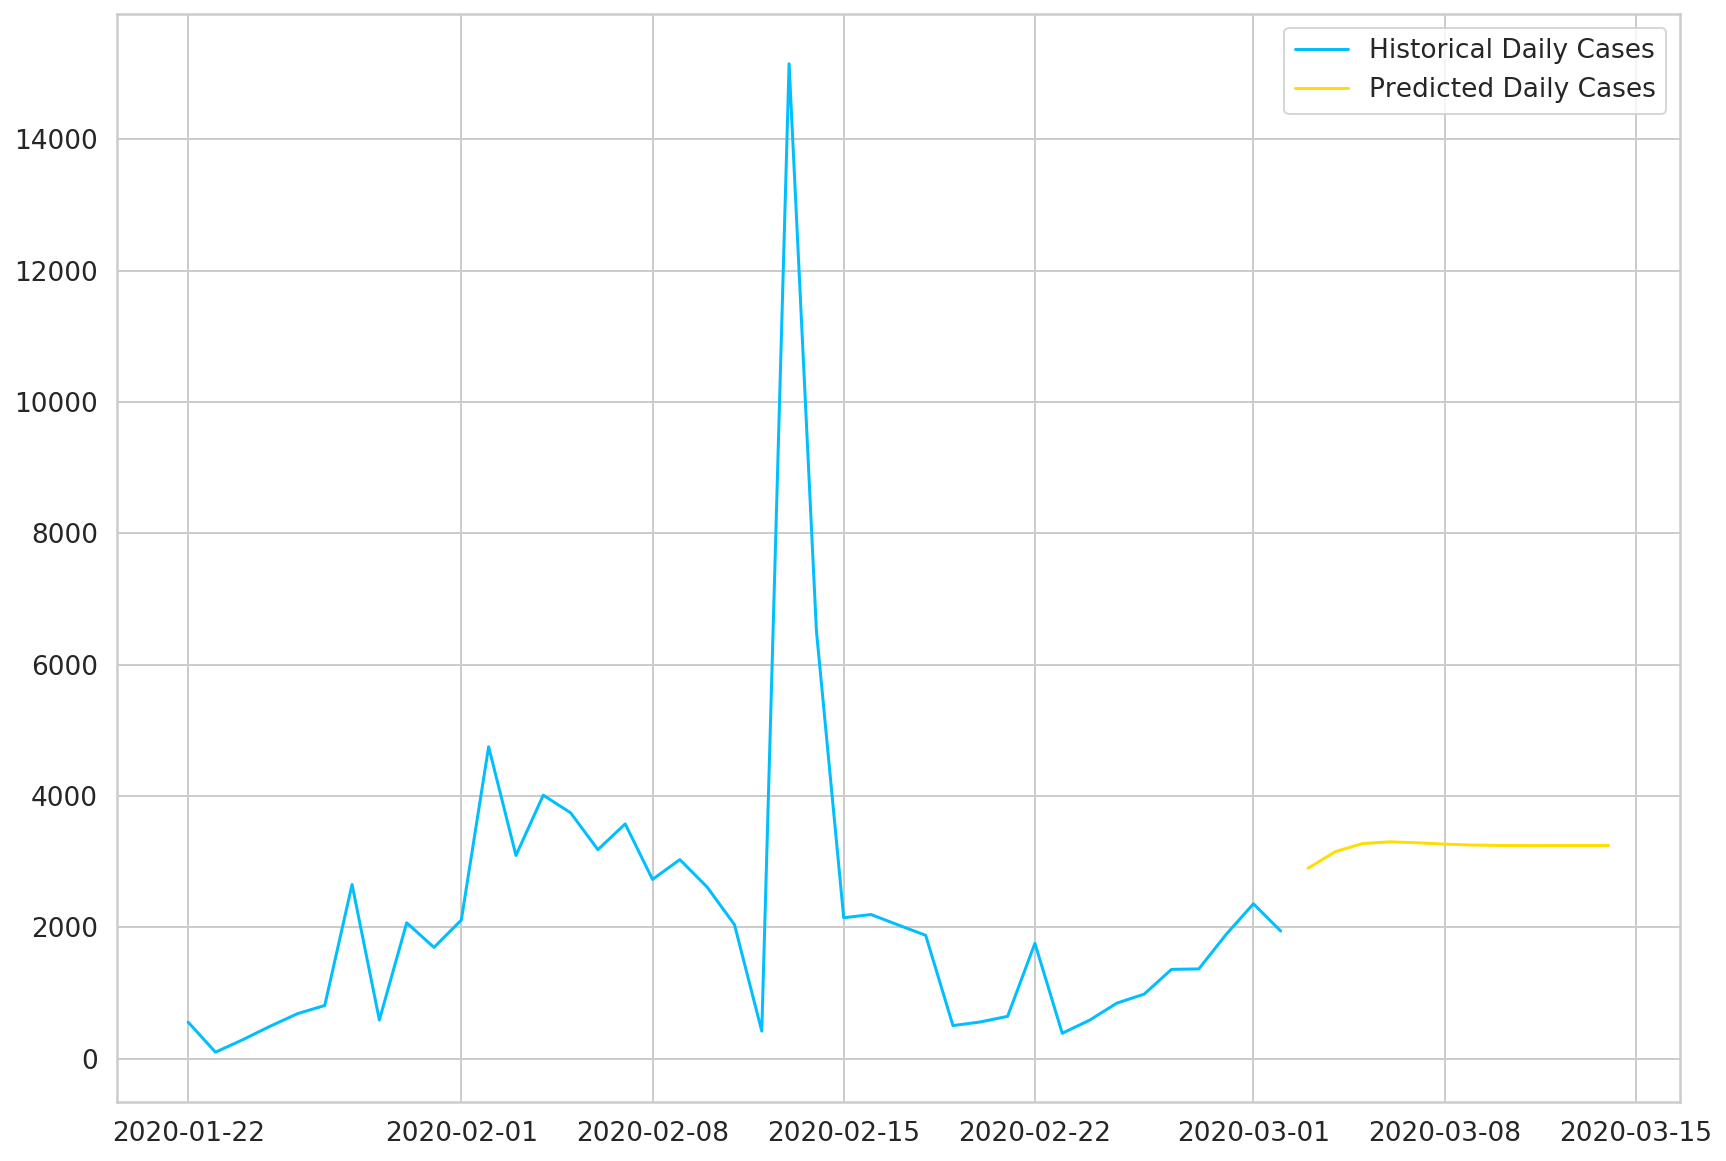

In [ ]:
plt.plot(daily_cases, label='Historical Daily Cases')
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();